In [219]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid')
import joblib
import pickle

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score, classification_report, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

In [182]:
df = pd.read_csv('Tesla_stock.csv')

df

Date       Close        High         Low        Open    Volume
0     2015-01-02   14.620667   14.883333   14.217333   14.858000  71466000
1     2015-01-05   14.006000   14.433333   13.810667   14.303333  80527500
2     2015-01-06   14.085333   14.280000   13.614000   14.004000  93928500
3     2015-01-07   14.063333   14.318667   13.985333   14.223333  44526000
4     2015-01-08   14.041333   14.253333   14.000667   14.187333  51637500
...          ...         ...         ...         ...         ...       ...
2661  2025-08-04  309.260010  312.119995  303.000000  309.079987  78683900
2662  2025-08-05  308.720001  312.450012  305.500000  308.950012  57961300
2663  2025-08-06  319.910004  320.470001  306.929993  307.890015  78523600
2664  2025-08-07  322.269989  322.399994  316.160004  319.790009  66658700
2665  2025-08-08  329.649994  335.149994  320.980011  321.429993  91006400

[2666 rows x 6 columns]

In [183]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2666 non-null   object 
 1   Close   2666 non-null   float64
 2   High    2666 non-null   float64
 3   Low     2666 non-null   float64
 4   Open    2666 non-null   float64
 5   Volume  2666 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 125.1+ KB


In [184]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month 
df['Day'] = df['Date'].dt.day
df.drop(columns = ['Date'], inplace = True)

In [185]:
df.head()

Close       High        Low       Open    Volume  Year  Month  Day
0  14.620667  14.883333  14.217333  14.858000  71466000  2015      1    2
1  14.006000  14.433333  13.810667  14.303333  80527500  2015      1    5
2  14.085333  14.280000  13.614000  14.004000  93928500  2015      1    6
3  14.063333  14.318667  13.985333  14.223333  44526000  2015      1    7
4  14.041333  14.253333  14.000667  14.187333  51637500  2015      1    8

In [186]:
df.isnull().sum()

Close     0
High      0
Low       0
Open      0
Volume    0
Year      0
Month     0
Day       0
dtype: int64

In [187]:
df.duplicated().sum()

np.int64(0)

In [188]:
# Creating MA7 and MA30 where MA7 is the 7-day moving average and MA30 is the 30-day moving average

df['MA7'] = df['Close'].rolling(window=7).mean()
df['MA30'] = df['Close'].rolling(window= 30).mean()

In [189]:
# Creating Daily returns which captures momentum direction

df['Return'] = df['Close'].pct_change()

In [190]:
# Creating Volatility, which is the standard deviation of the closing price over a 7-day window

df['Volatility'] = df['Close'].rolling(window= 7).std()


In [191]:
# Calculating RSI (relative strength index) - Overbrought/ Oversold signal
# RSI ranges from 0-100
# Above 70 - Overbrought (Price too high, might drop)
# Above 20 - Oversold (Price too low, might rise)

def compute_rsi(data, window= 14):
   delta = data.diff()
   gain = np.where( delta > 0, delta, 0)
   loss = np.where( delta < 0, -delta, 0)
   avg_gain = pd.Series(gain).rolling(window= window).mean()
   avg_loss = pd.Series(loss).rolling(window = window).mean()
   rs = avg_gain/ avg_loss
   return 100 - (100/ (1 + rs))

df['RSI'] = compute_rsi(df['Close'])

In [192]:
df['Target'] = df['Close'].shift(-1)
df.dropna(inplace=True)  # drop last row (no tomorrow's price)
df.drop(columns = ['Close'], inplace=True)


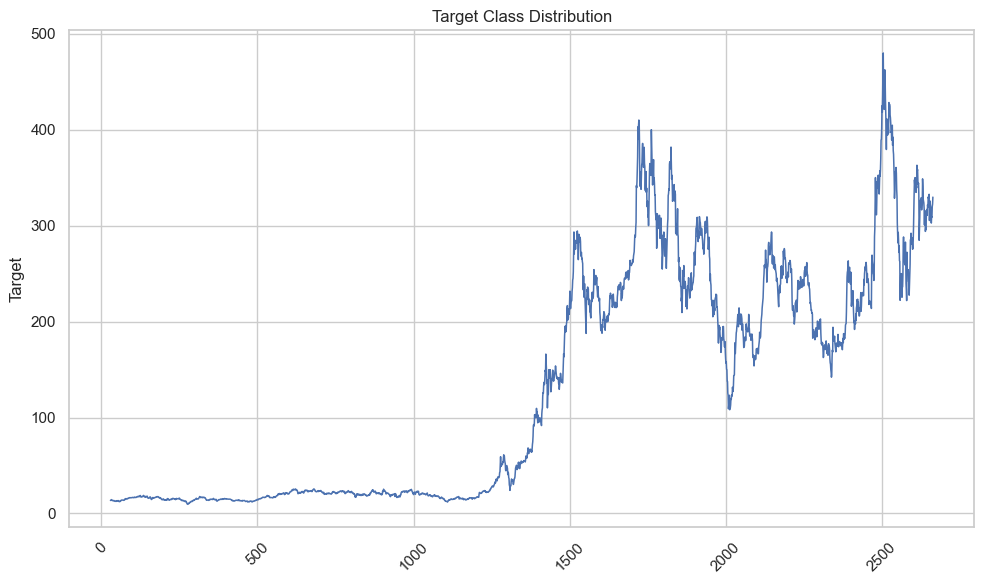

In [193]:
plt.figure(figsize=(10,6))
sns.lineplot(df['Target'], linewidth=1.1, palette='flare')
plt.title('Target Class Distribution')
plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()

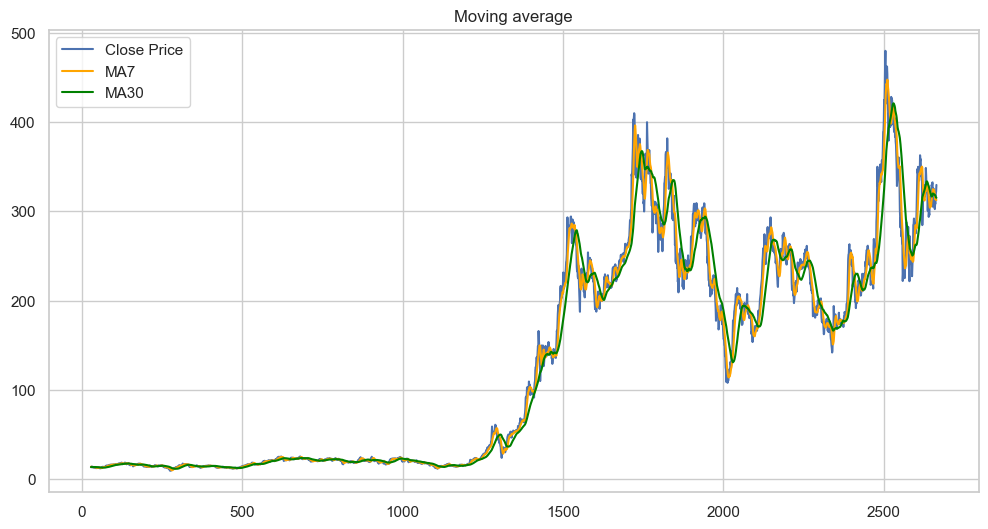

In [194]:
plt.figure(figsize=(12,6))
plt.plot(df['Target'], label = 'Close Price')
plt.plot(df['MA7'], label = 'MA7', color = 'orange')
plt.plot(df['MA30'], label = 'MA30', color = 'green')
plt.legend()
plt.title('Moving average')
plt.show()

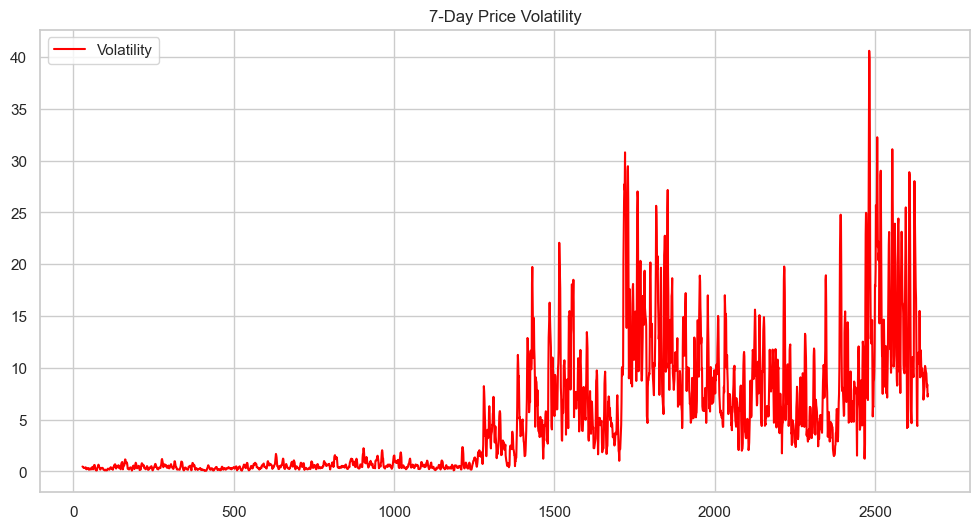

In [195]:
plt.figure(figsize=(12,6))
plt.plot(df['Volatility'], label = 'Volatility', color = 'red')
plt.legend()
plt.title('7-Day Price Volatility')
plt.show()

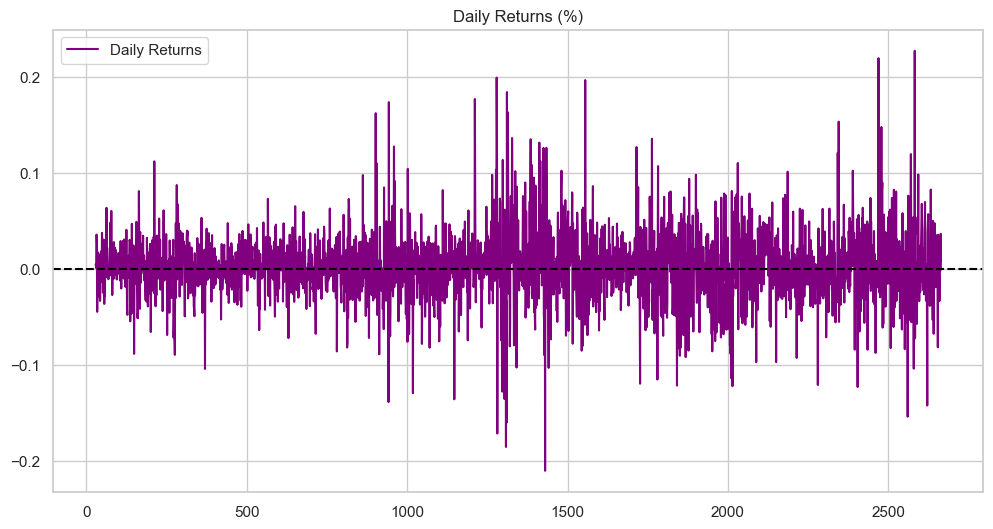

In [196]:
plt.figure(figsize=(12,6))
plt.plot(df['Return'], label = 'Daily Returns', color = 'purple')
plt.axhline(0, color = 'black', linestyle = '--')
plt.legend()
plt.title('Daily Returns (%)')
plt.show()

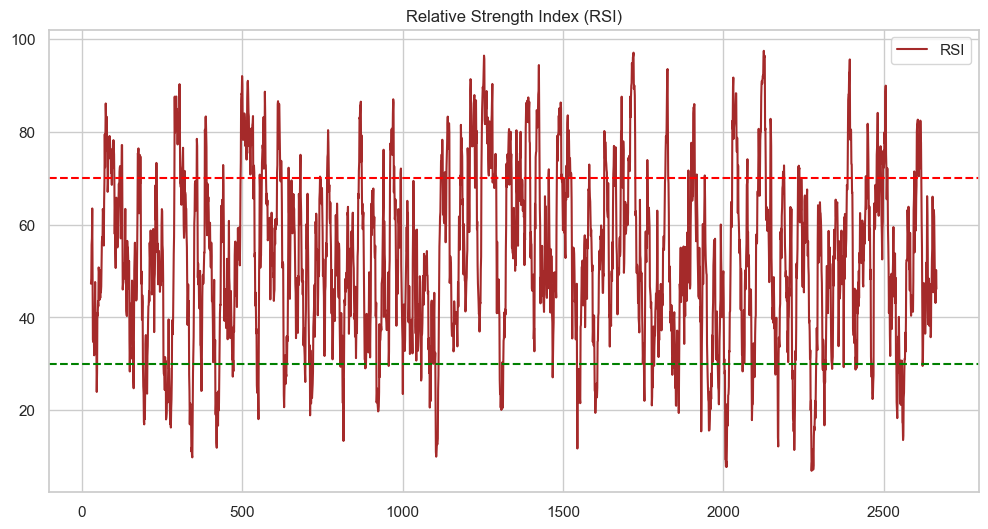

In [197]:
plt.figure(figsize=(12,6))
plt.plot(df['RSI'], label = 'RSI', color = 'brown')
plt.axhline(70, color = 'red', linestyle = '--')
plt.axhline(30, color = 'green', linestyle= '--')
plt.legend()
plt.title('Relative Strength Index (RSI)')
plt.show()

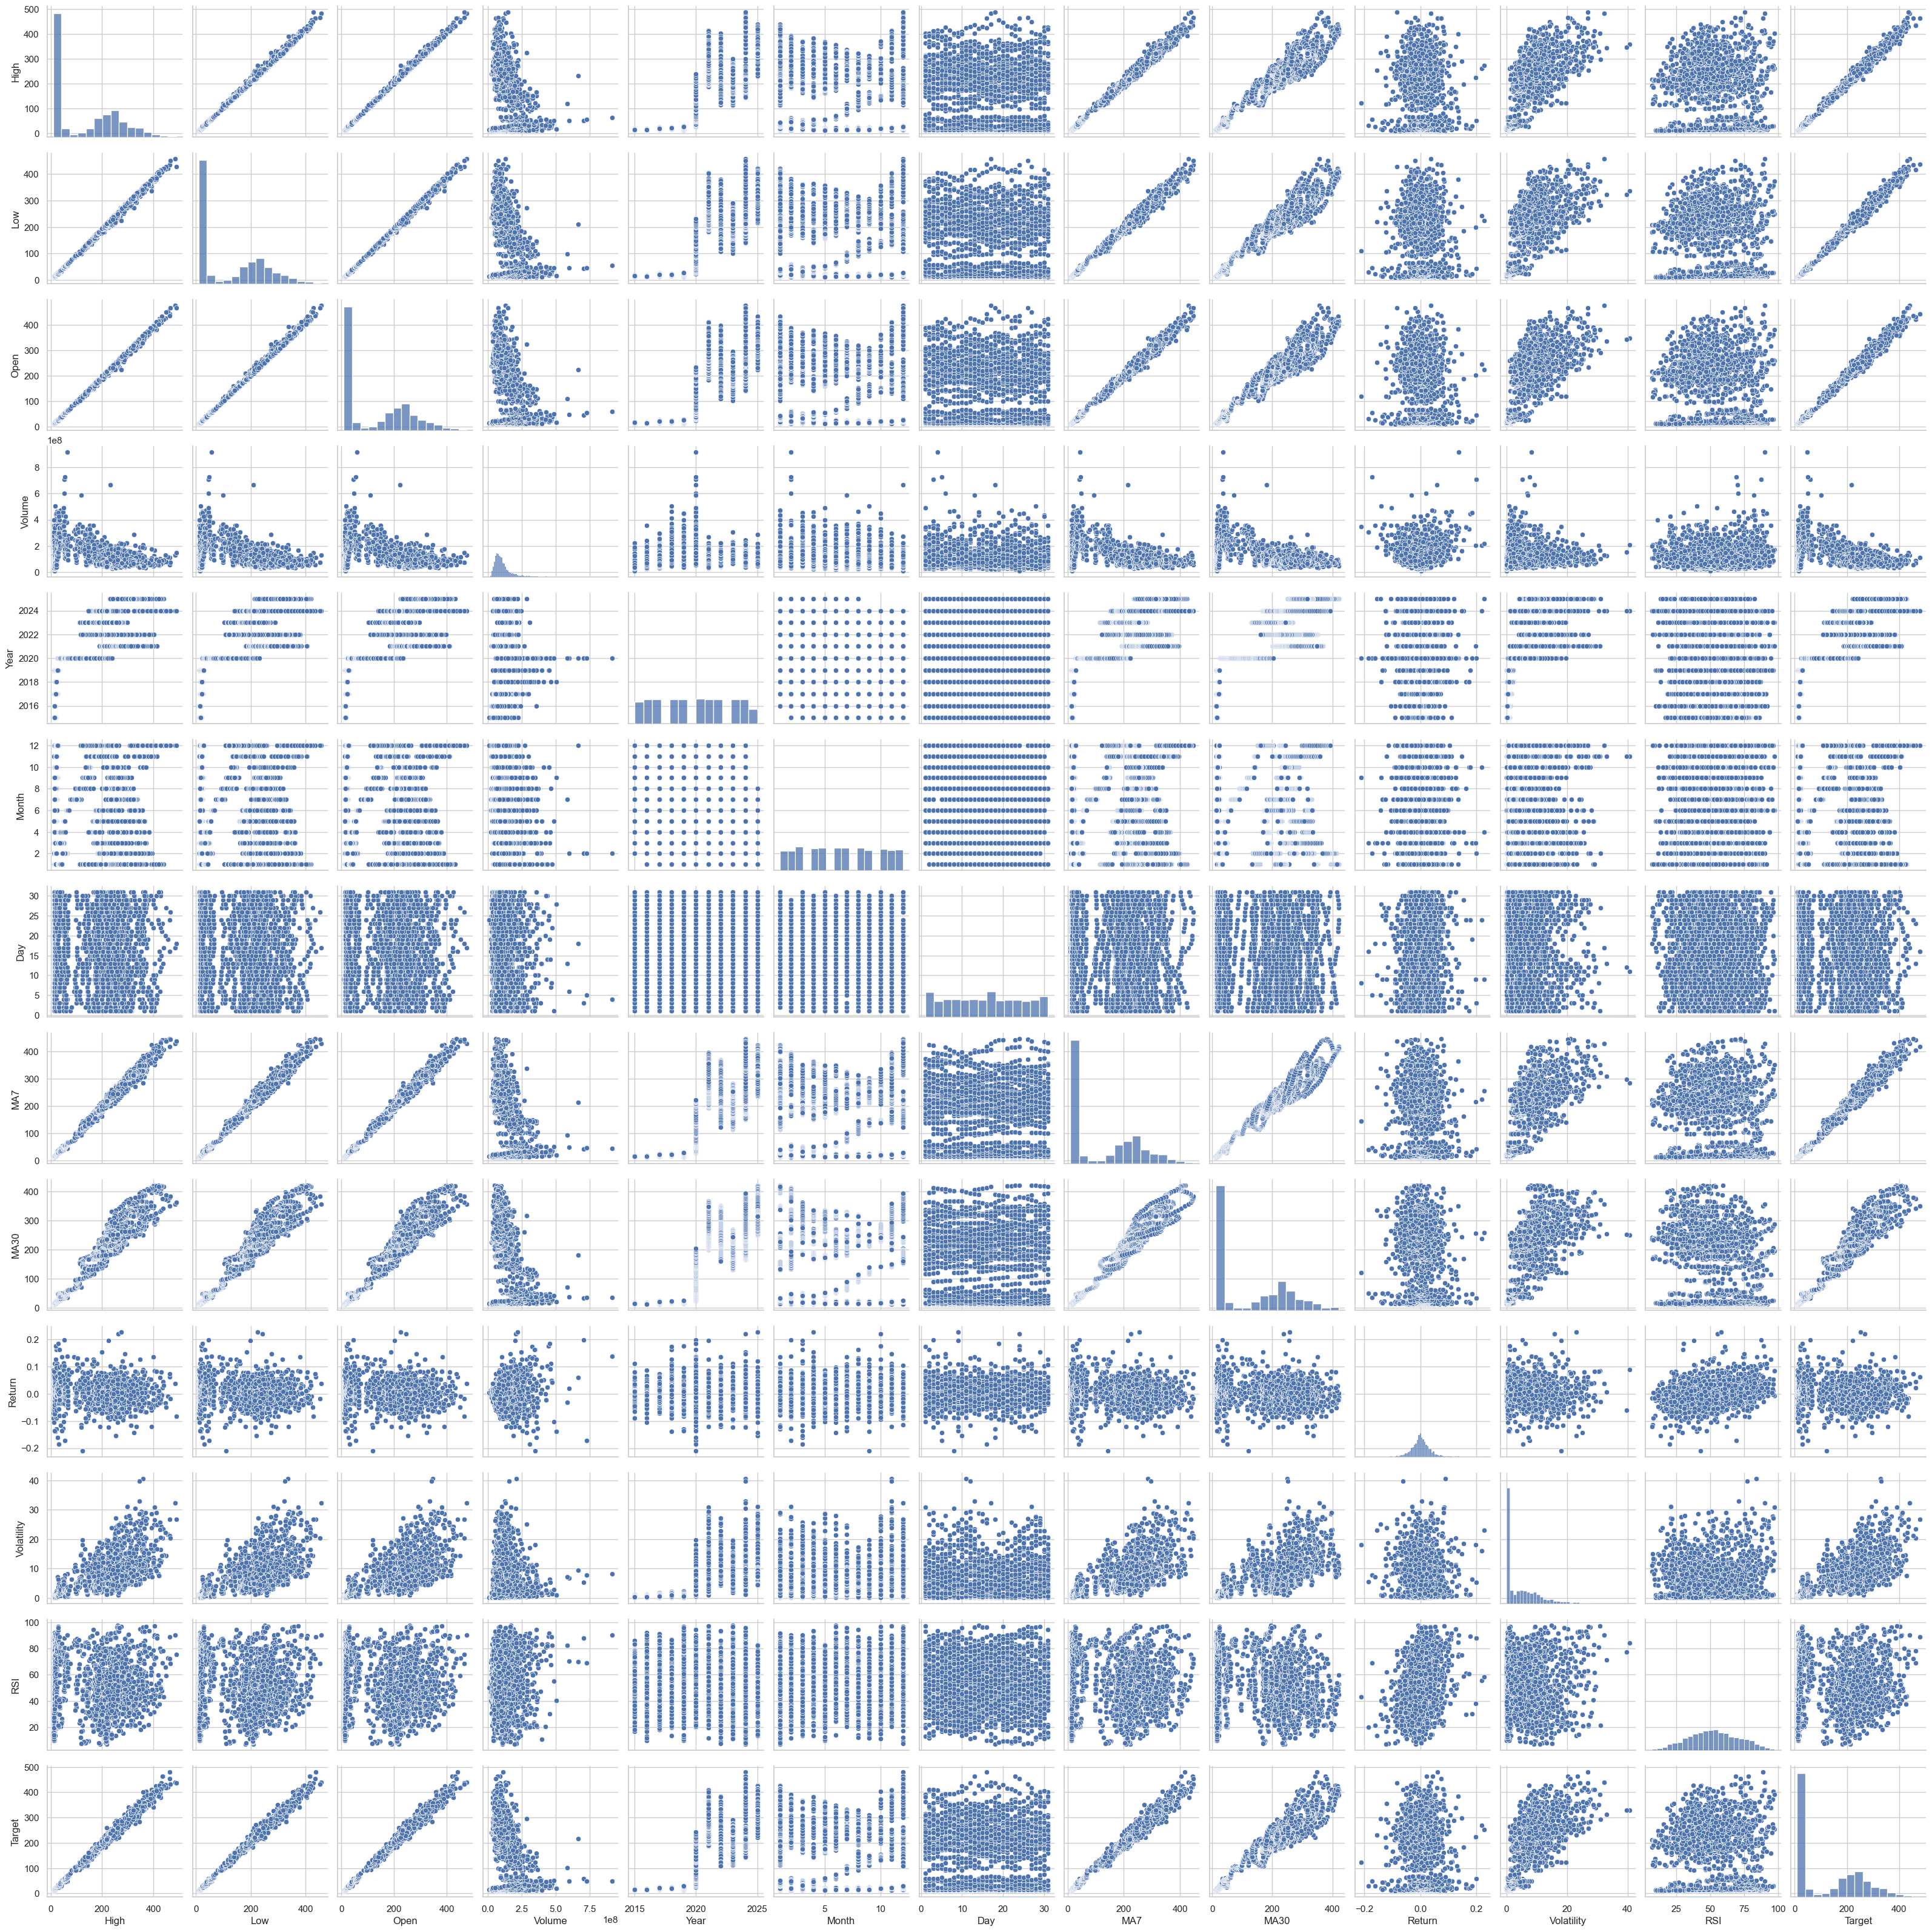

In [198]:
sns.pairplot(df)

<Axes: >

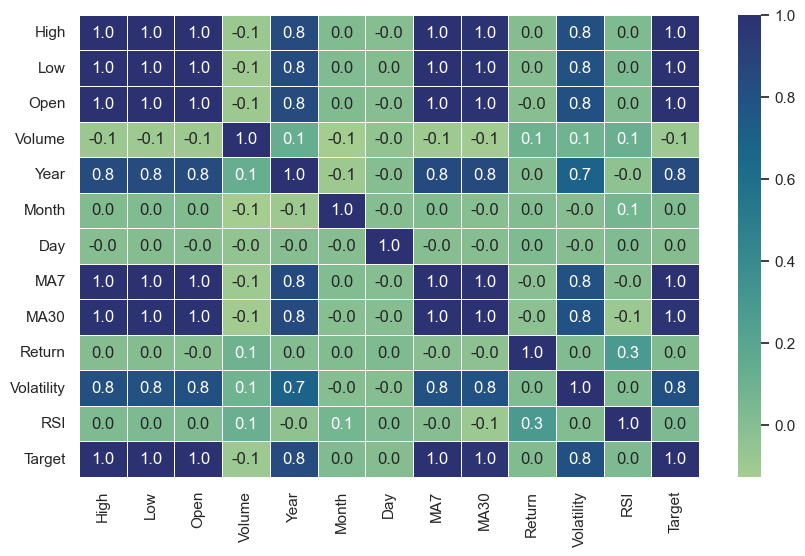

In [199]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, fmt=".1f", linewidths=.5, cmap = 'crest')

<Axes: >

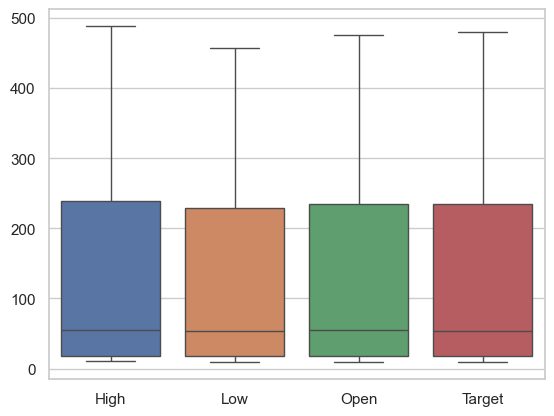

In [200]:
sns.boxplot(df[['High', 'Low', 'Open', 'Target']])

<Axes: >

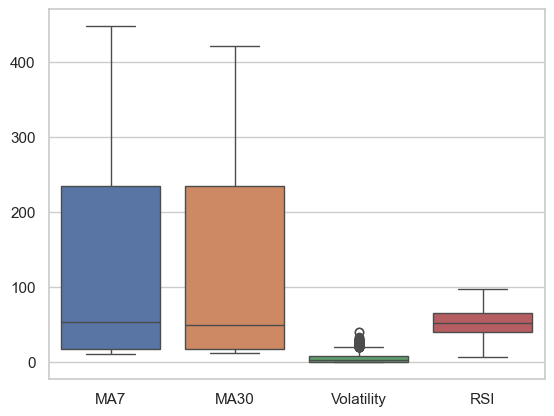

In [201]:
sns.boxplot(df[['MA7', 'MA30','Volatility','RSI']])

<Axes: >

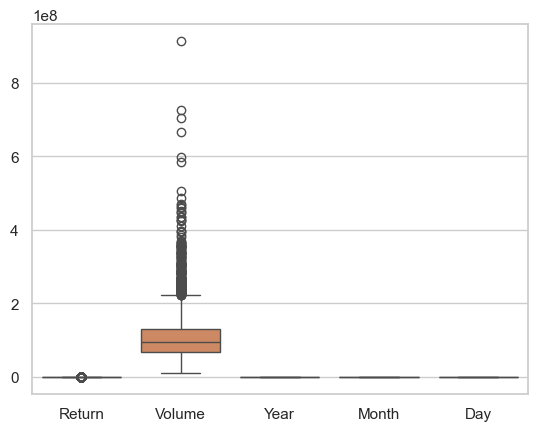

In [202]:
sns.boxplot(df[['Return','Volume','Year','Month','Day']])

In [203]:
def remove_outliers(df):
    numeric_col = df.select_dtypes(include='number').columns
    mask = pd.Series(True, index=df.index)
    for col in numeric_col:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        mask &= df[col].between(lower, upper)
    return df[mask]

df = remove_outliers(df)


In [204]:
df.reset_index(drop=True, inplace=True)  # does it in place


In [205]:
X = df.drop(columns=['Target'], axis = 1)
y = df['Target']

In [206]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [207]:
numeric_features = ['Open', 'Low','High','Volume','Year','Month','Day', 'MA7','MA30','Return','RSI','Volatility']
numeric_transform = Pipeline(steps=[
   ('impute', SimpleImputer(strategy='median')),
   ('scaler', StandardScaler())
])

In [208]:
preprocessor = ColumnTransformer(transformers=[
   ('Preprocessor', numeric_transform, numeric_features)
])

In [209]:
model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])

In [210]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('Preprocessor',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Open', 'Low', 'High',
                                                   'Volume', 'Year', 'Month',
                                                   'Day', 'MA7', 'MA30',
                                                   'Return', 'RSI',
                                                   'Volatility'])])),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_byleve...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=300, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [211]:
y_pred = model.predict(X_test)

In [212]:
r2 = r2_score(y_test, y_pred)
r2_percent = r2 * 100
print("R² Score (%):", r2_percent)

R² Score (%): 92.54181691416991


In [213]:
cv_score = cross_val_score(model, X_train, y_train, cv = 10)
print('Cross Validation Score : ',100*round(cv_score.mean(), 4))


Cross Validation Score :  84.11


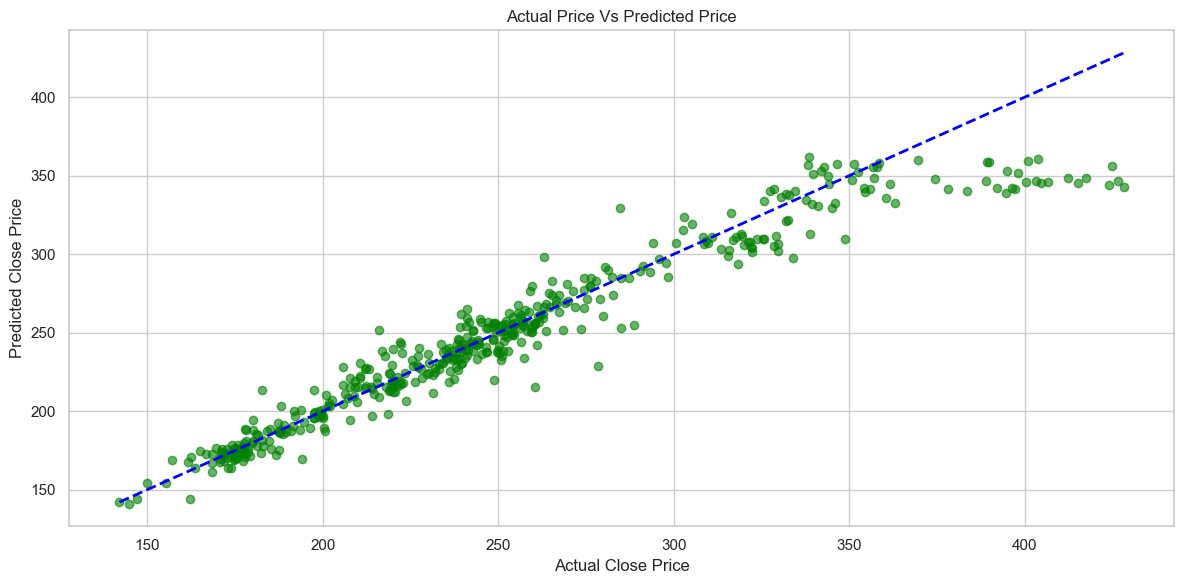

In [214]:
plt.figure(figsize=(12,6))
plt.scatter(y_test, y_pred, alpha = 0.6, color='green')
plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()], color = 'blue', lw = 2, linestyle = '--')
plt.title('Actual Price Vs Predicted Price')
plt.xlabel('Actual Close Price')
plt.ylabel('Predicted Close Price')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Predicted Stock Price')

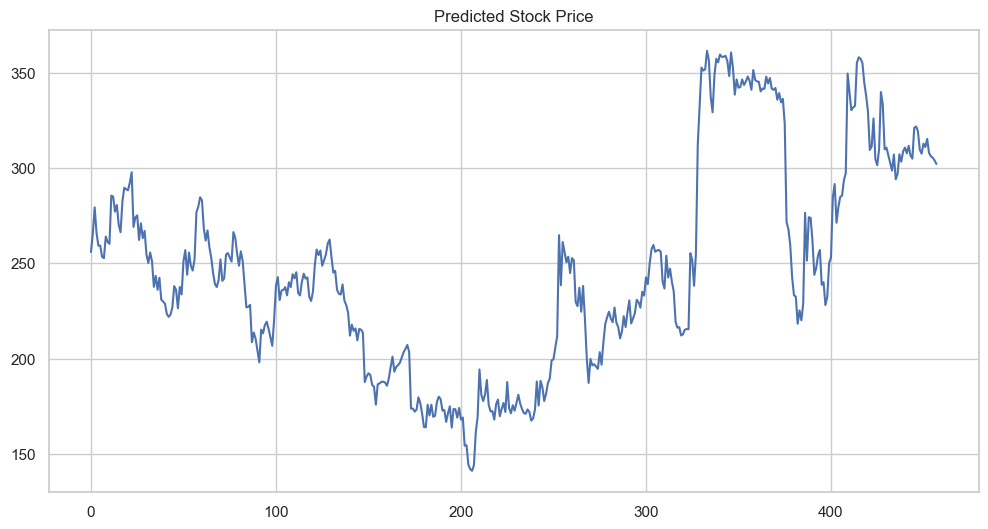

In [215]:
plt.figure(figsize=(12,6))
sns.lineplot(y_pred)
plt.title('Predicted Stock Price')

In [216]:
df.sample(4)

High         Low        Open     Volume  Year  Month  Day  \
270    15.648667   14.802000   15.491333   74232000  2016      3   23   
1738  136.679993  127.010002  136.559998  195680300  2023      1   18   
1260  141.000000  136.506668  138.350006   59565300  2020     11   12   
1838  258.369995  240.699997  250.070007  179990600  2023      6   26   

             MA7        MA30    Return  Volatility        RSI      Target  
270    15.186000   12.925489 -0.049778    0.494234  68.960175   15.183333  
1738  124.010000  137.867667 -0.020610    4.595746  64.904572  127.169998  
1260  140.453807  141.382110 -0.012874    3.291089  46.978253  136.166672  
1838  258.944286  217.139667 -0.060600   10.085540  61.039940  250.210007

In [217]:
features = ['Open', 'Low','High','Volume','Year','Month','Day', 'MA7','MA30','Return','RSI','Volatility']
x_new = pd.DataFrame([[15.73, 15.36,16.25, 98853000, 2015, 8, 21, 16.47, 17.17, -0.04, 0.68, 34.81]], columns=features)
res = model.predict(x_new)
print("Stock Price Prediction on given info for Tomarrow : ",res[0])


Stock Price Prediction on given info for Tomarrow :  19.188808


In [220]:
pickle.dump(model,open("StockPrice.pkl","wb"))